In [87]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [88]:
import numpy as np
np.random.seed(100)

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pysensors as ps

# Data Generation

In [89]:
def generate_simple_flow(n_timesteps, nx, ny):
    # create a moving Gaussian "blob" that travels across the domain.
    data = np.zeros((n_timesteps, nx, ny))
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)
    Xgrid, Ygrid = np.meshgrid(x, y, indexing='ij')

    for t in range(n_timesteps):
        # The center of the blob moves linearly through the domain.
        cx = 0.8 - 0.6 * (t / n_timesteps)
        cy = 0.2 + 0.6 * (t / n_timesteps)
        data[t] = np.exp(-((Xgrid - cx)**2 + (Ygrid - cy)**2) / 0.01)

    return data

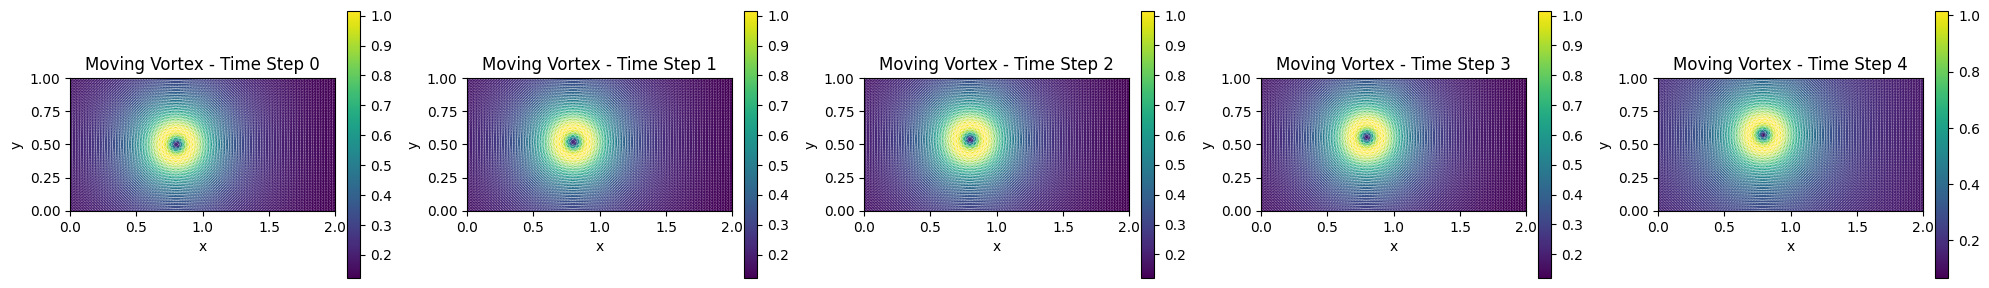

In [ ]:
def generate_moving_vortex(n_timesteps, nx, ny, lx=2, ly=1, plot_series=False, plot_interval=1):
    """
    Generate a moving vortex flow field based on the Lamb–Oseen vortex solution.
    The instantaneous velocity field is computed as:
    
        u(x,y,t) = - (Gamma/(2π)) * ( (y - y0(t)) / r² ) * [1 - exp(-r²/r_c²)]
        v(x,y,t) =   (Gamma/(2π)) * ( (x - x0(t)) / r² ) * [1 - exp(-r²/r_c²)]
        
    where r² = (x - x0(t))² + (y - y0(t))².
    """
   # Vortex parameters
    Gamma = 1.0
    r_c = 0.1
    x_center = 0.5
    y_center = 0.5
    r_move = 0.3  # amplitude of the center's circular motion
    cycle_length = 100

    data    = np.zeros((n_timesteps, nx, ny))
    u_field = np.zeros((n_timesteps, nx, ny))
    v_field = np.zeros((n_timesteps, nx, ny))
    
    # Define physical domain: x in [0,lx], y in [0,ly]
    x = np.linspace(0, lx, nx)
    y = np.linspace(0, ly, ny)
    # Use 'ij' indexing: first index corresponds to x, second to y.
    Xgrid, Ygrid = np.meshgrid(x, y, indexing='ij')
    
    for t in range(n_timesteps):
        theta = 2 * np.pi * t / cycle_length
        x0 = x_center + r_move * np.cos(theta)
        y0 = y_center + r_move * np.sin(theta)
        
        dx = Xgrid - x0
        dy = Ygrid - y0
        r2 = dx**2 + dy**2
        # Avoid division by zero:
        r2[r2 == 0] = 1e-10
        
        factor = 1 - np.exp(-r2 / (r_c**2))
        u = - (Gamma / (2 * np.pi)) * (dy / r2) * factor
        v =   (Gamma / (2 * np.pi)) * (dx / r2) * factor
        
        u_field[t] = u
        v_field[t] = v
        data[t] = np.sqrt(u**2 + v**2)
    
    if plot_series:
        fig, axes = plt.subplots(1, n_timesteps, figsize=(4 * n_timesteps, 4))
        for t in range(0, n_timesteps, plot_interval):
            ax = axes[t]
            # Since data[t] is stored as (nx, ny) with x in axis 0 and y in axis 1,
            # we transpose it so that imshow interprets the first dimension as y (vertical)
            # and the second as x (horizontal). We set extent=[0,2,0,1] for the physical domain.
            im = ax.imshow(data[t].T, origin='lower', extent=[0,lx,0,ly], cmap='viridis')
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            # The quiver uses Xgrid and Ygrid from meshgrid with indexing='ij',
            # so Xgrid[i,j] = x[i] and Ygrid[i,j] = y[j]. That matches our physical domain.
            ax.quiver(Xgrid, Ygrid, u_field[t], v_field[t], color='white', scale=10, width=0.0007, pivot='mid')
            ax.set_title(f"Moving Vortex - Time Step {t}")
            ax.set_xlabel("x")
            ax.set_ylabel("y")
        plt.tight_layout()
        plt.show()    
        
    return u_field, v_field

_ = generate_moving_vortex(5, 100, 50, lx=2, ly=1, plot_series=True, plot_interval=1)

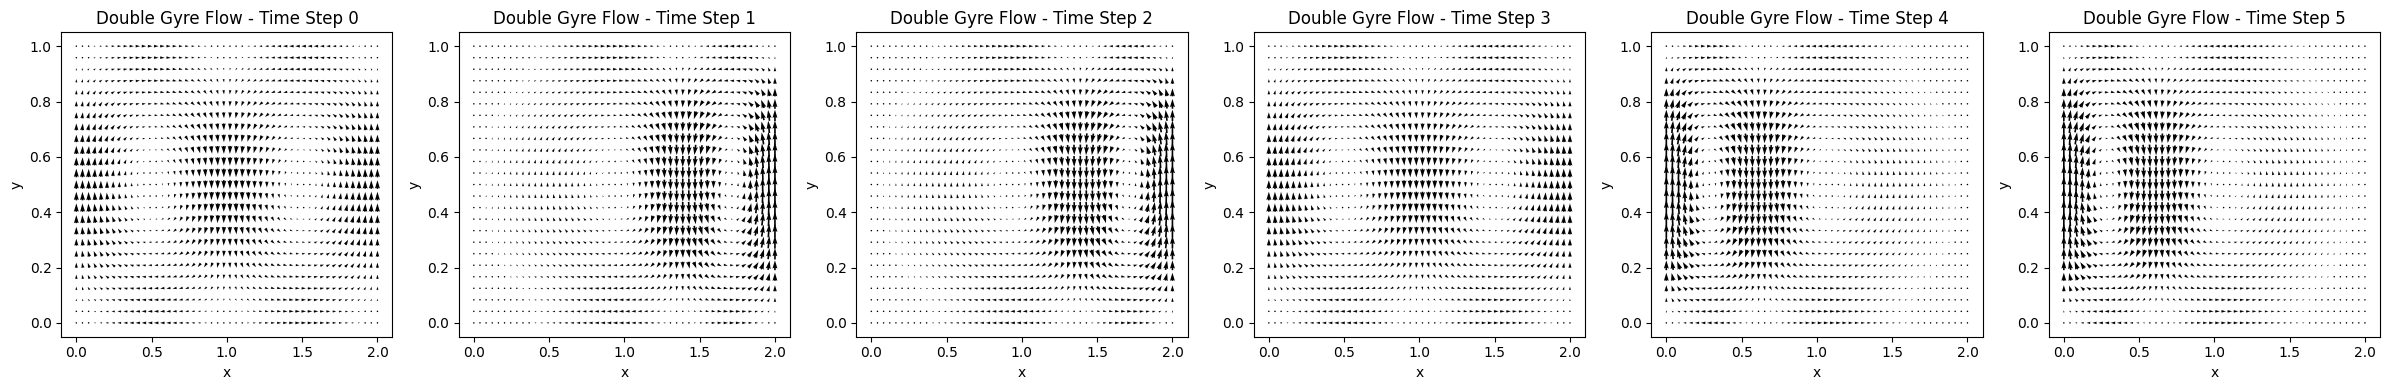

In [ ]:
def generate_double_gyre_flow(n_timesteps, nx, ny, lx=2, ly=1,
                              A=0.1, epsilon=0.25, period=20, 
                              plot_series=False):
    """   
    The double gyre is defined on the domain x ∈ [0,2] and y ∈ [0,1]. Its velocity field is given by:
    
        f(x,t) = ε sin(ω t) x² + (1 - 2ε sin(ω t)) x
        u(x,y,t) = -π A sin(π f(x,t)) cos(π y)
        v(x,y,t) =  π A cos(π f(x,t)) sin(π y) [2ε sin(ω t) x + (1 - 2ε sin(ω t))]
    
    Parameters:
      n_timesteps : Number of timesteps.
      nx, ny : Number of spatial grid points in x and y directions.
      A : Amplitude of the velocity.
      epsilon : Strength of the time-periodic oscillation.
      period : Number of intervals for flow to repeat
      plot_series 
    
    Returns:
       u_field, v_field 
    """
    omega = 2*np.pi / period

    data    = np.zeros((n_timesteps, nx, ny))
    u_field = np.zeros((n_timesteps, nx, ny))
    v_field = np.zeros((n_timesteps, nx, ny))
    # Domain: x in [0,lx], y in [0,ly]
    x = np.linspace(0, lx, nx)
    y = np.linspace(0, ly, ny)

    Xgrid, Ygrid = np.meshgrid(x, y, indexing='ij')
    
    for t in range(n_timesteps):
        # Time variable (assuming unit time steps)
        time = t
        sin_omega_t = np.sin(omega * time)
        
        # Define the function f(x,t) and its derivative with respect to x:
        # f(x,t) = ε sin(ω t) x² + (1 - 2ε sin(ω t)) x
        f = epsilon * sin_omega_t * Xgrid**2 + (1 - 2*epsilon*sin_omega_t) * Xgrid
        dfdx = 2 * epsilon * sin_omega_t * Xgrid + (1 - 2*epsilon*sin_omega_t)
        
        # Compute velocity components
        u = - np.pi * A * np.sin(np.pi * f) * np.cos(np.pi * Ygrid)
        v =   np.pi * A * np.cos(np.pi * f) * np.sin(np.pi * Ygrid) * dfdx
        
        u_field[t] = u
        v_field[t] = v
        data[t] = np.sqrt(u**2 + v**2)
    
    if plot_series:
        fig, axes = plt.subplots(1, n_timesteps, figsize=(4 * n_timesteps, 4))
        for t in range(0, n_timesteps, 1):
            ax = axes[t]
            
            # Plot magnitute
            # im = ax.imshow(data[t].T, origin='lower', extent=[0,lx,0,ly], cmap='viridis')
            # plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            
            # Plot direction
            ax.quiver(Xgrid, Ygrid, u_field[t], v_field[t], color='black', 
                       scale_units='xy', scale=10, width=0.005, pivot='mid')
            
            ax.set_title(f"Double Gyre Flow - Time Step {t}")
            ax.set_xlabel("x")
            ax.set_ylabel("y")
        plt.tight_layout()
        plt.show()
    
    return u_field, v_field


# Generate the double gyre flow data over 50 timesteps on a 100x50 grid.
_ = generate_double_gyre_flow(
    n_timesteps=6, nx=50, ny=25, lx=2, ly=1,
    A=0.1, epsilon=0.5, 
    period=6,
    plot_series=True
)


# Data Transformation

In [92]:
def rotate_data_90(data):
    """
    Rotate each snapshot by 90 degrees counterclockwise.
    
    Parameters
    ----------
    data : np.ndarray of shape (n_timesteps, nx, ny)
        The flow field snapshots. data[t] is shape (nx, ny).
        
    Returns
    -------
    data_rotated : np.ndarray
        The rotated data, each snapshot shape is now (ny, nx).
    """
    # We'll collect each rotated snapshot, then stack them back into an array.
    data_rotated_list = []
    for t in range(data.shape[0]):
        # Rotate data[t] (shape (nx, ny)) by 90 deg counterclockwise
        # np.rot90() outputs shape (ny, nx)
        slice_rot = np.rot90(data[t])
        data_rotated_list.append(slice_rot)
    
    # Stack them along the time dimension again
    data_rotated = np.stack(data_rotated_list, axis=0)
    return data_rotated


In [93]:
def reflect_data_y(data):
    """
    Reflect each snapshot about the horizontal midline in y.
    
    Parameters
    ----------
    data : np.ndarray of shape (n_timesteps, nx, ny)
        The flow field snapshots. For each t, data[t] is shape (nx, ny).
        The second dimension is y, so flipping it reverses y-coordinates.

    Returns
    -------
    data_reflected : np.ndarray of shape (n_timesteps, nx, ny)
        The data reflected about y = L_y/2.
    """
    data_reflected = data[..., ::-1]
    return data_reflected

Original Data:
[[[ 1  2  3]
  [ 4  5  6]
  [ 7  8  9]
  [10 11 12]]]

Reflected Data (about y-mid domain):
[[[ 3  2  1]
  [ 6  5  4]
  [ 9  8  7]
  [12 11 10]]]

Rotated Data (90° counterclockwise):
[[[ 3  6  9 12]
  [ 2  5  8 11]
  [ 1  4  7 10]]]


array([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]])

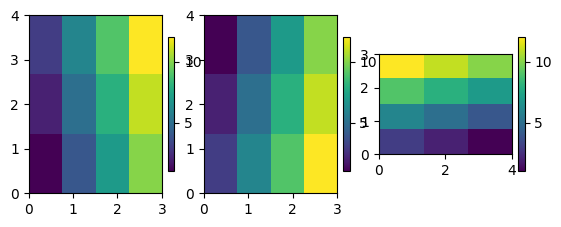

In [94]:
data = np.array([[
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9],
    [10, 11, 12]
]])

print("Original Data:")
print(data)

data_reflected = reflect_data_y(data)
print("\nReflected Data (about y-mid domain):")
print(data_reflected)

data_rotated = rotate_data_90(data)
print("\nRotated Data (90° counterclockwise):")
print(data_rotated)

fig, axes = plt.subplots(1, 3)
im = axes[0].imshow(data.T, origin='lower', extent=[0, 3, 0, 4], cmap='viridis')
plt.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)
im = axes[1].imshow(data_reflected.T, origin='lower', extent=[0, 3, 0, 4], cmap='viridis')
plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
im = axes[2].imshow(data_rotated.T, origin='lower', extent=[0, 4, 0, 3], cmap='viridis')
plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

data.reshape(1, 4 * 3)

# Sensor Placement

In [95]:
def process_interval(data_interval, n_sensors, n_basis_modes):
    """
    Given a batch of fluid flow data for a time interval, 
    use PySensors to find optimal sensor locations.
    
    Parameters:
        data_interval : (n_timesteps, nx, ny) for the interval.
        n_sensors : number of sensors to select.
    
    Returns:
        sensor_coords
    """
    n_timesteps, nx, ny = data_interval.shape
    # Flatten each 2D snapshot into a 1D vector (each sample is one time instance)
    # flattens row-wise (but rmr row is a col in our 2d map)
    # so append on the slices of y-axis together
    X = data_interval.reshape(n_timesteps, nx * ny)
    
    # axis=0: means do it col-wise (grid-point-wise); axis=1: means do it row-wise (time-step-wise)
    X = X - X.mean(axis=0)
    # X = X - X.mean(axis=1, keepdims=True) # center the data

    # std_loc = X.std(axis=0, keepdims=True)
    # X = X / std_loc

    # std_time = X.std(axis=1, keepdims=True)
    # X = X / std_time
    
    basis = ps.basis.SVD(n_basis_modes=n_basis_modes, algorithm='arpack')
    model = ps.SSPOR(n_sensors=n_sensors, basis=basis)
    model.fit(X)
    
    sensor_indices = model.selected_sensors
    
    # Convert the flat indices back to 2D coordinates on the nx x ny grid.
    sensor_coords = np.array(np.unravel_index(sensor_indices, (nx, ny))).T # get index in row-major form by default
    return sensor_coords


In [96]:
def plot_optimal_sensors(lx, ly, nx, ny,
                         data, n_sensors, 
                         n_timesteps, interval_length, n_basis_modes):

    intervals = range(0, n_timesteps, interval_length)
    fig, axes = plt.subplots(1, len(list(intervals)), figsize=(4 * len(list(intervals)), 4))

    intervals = list(range(0, n_timesteps, interval_length))
    for i, start in enumerate(intervals):
        end = min(start + interval_length, n_timesteps)
        data_interval = data[start:end]
        
        sensor_coords = process_interval(data_interval, n_sensors, n_basis_modes)
        
        # For visualization, use mean
        avg_field = data_interval.mean(axis=0)
        ax = axes[i] if len(intervals) > 1 else axes

        # # Rotated data
        # im = ax.imshow(avg_field.T, origin='lower', extent=[0, ly, 0, lx], cmap='viridis')
        # sensor_x = sensor_coords[:, 0] * (ly / (ny - 1))
        # sensor_y = sensor_coords[:, 1] * (lx / (nx - 1))

        im = ax.imshow(avg_field.T, origin='lower', extent=[0, lx, 0, ly], cmap='viridis')
        sensor_x = sensor_coords[:, 0] * (lx / (nx - 1))
        sensor_y = sensor_coords[:, 1] * (ly / (ny - 1))

        ax.scatter(sensor_x, sensor_y, 
                    color='red', marker='o', s=50)
        ax.set_title(f"Time {start} to {end}")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

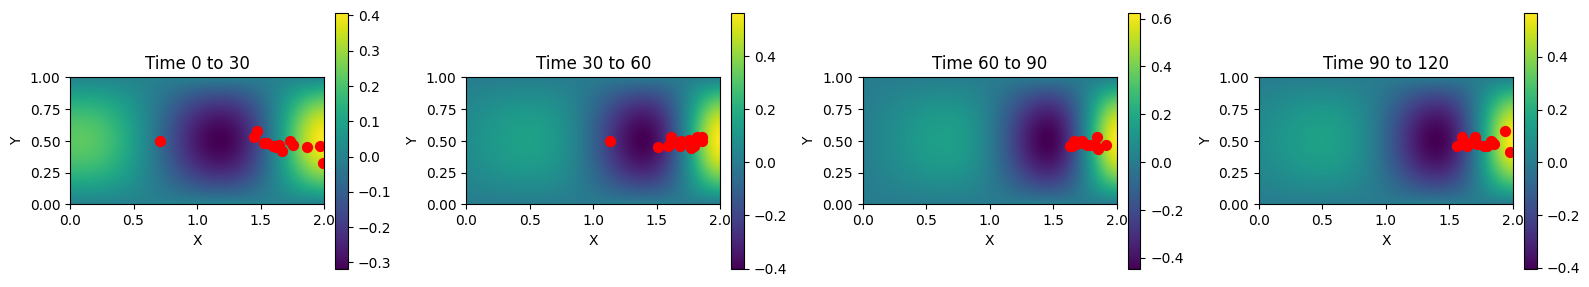

In [97]:
# --- Parameters ---
n_sensors = 15         # Number of sensors to select in each interval
interval_length = 30   # Number of timesteps per batch
n_timesteps = 120      # Total number of timesteps in the dataset
n_basis_modes = 20     # Number of modes in data

nx, ny = 300, 150 # number of grid points along each axis
lx, ly = 2, 1
data = generate_double_gyre_flow(
    n_timesteps=n_timesteps, nx=nx, ny=ny, lx=lx, ly=ly,
    A=0.1, epsilon=0.5, period=300
)

# nx, ny = 100, 50 # number of grid points along each axis
# lx, ly = 1, 1
# data = generate_moving_vortex(n_timesteps, nx, ny, lx=lx, ly=ly)

# data = rotate_data_90(data)

plot_optimal_sensors(lx, ly, nx, ny,
                         data, n_sensors, 
                         n_timesteps, interval_length, n_basis_modes)


# TODO: try shiftting the data up